In [27]:
%matplotlib inline
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import utils.data as data
import utils.sub_architectures as sub_architectures

In [28]:
def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

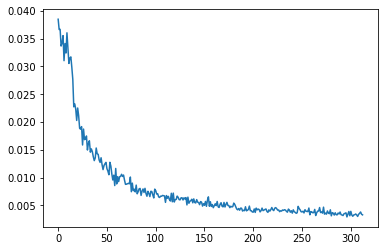

Loss After 1 Epochs: 0.007994583

Rendering Results...


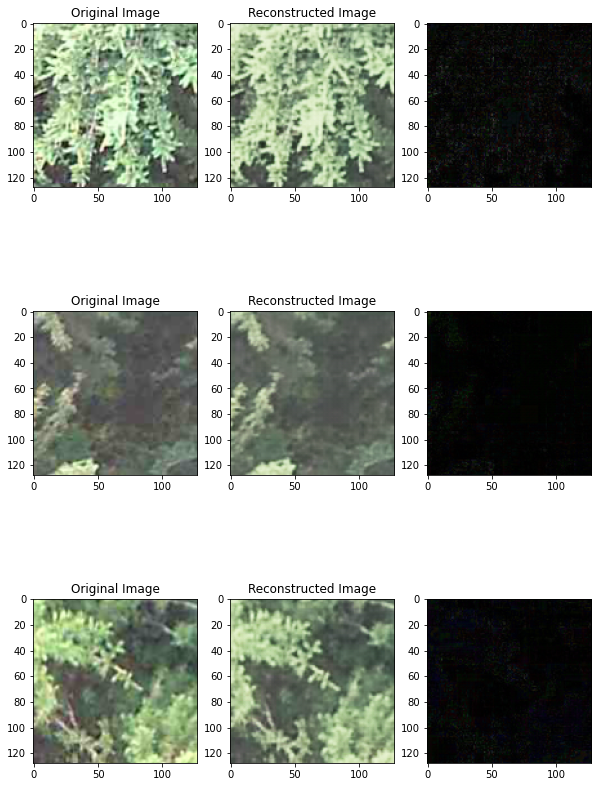

In [30]:
### Trains a (sub-architecture) autoencoder given Model type
def train_subarchitecture(
    model, 
    optim, 
    lr, 
    num_epochs, 
    train_loader, 
    val_loader, 
    val_data,
    device,
    saved_model_filename,
    plot_training=False, 
    save_model=True,
):

    device = get_device()
    model = model.to(device=device)

    criterion = nn.MSELoss() #Loss function
    optimizer = optim(model.parameters(), lr=lr) #Optimizer

    lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min", 
        factor=0.1, 
        patience=2, 
        cooldown=1, 
        verbose=True)

    # Training
    train_loss = []
    model.train()
    
    print("Training Progress: ")
    time.sleep(0.5)

    for epoch in range(num_epochs):
        epoch_losses = []
        for x in tqdm(train_loader):

            x = x.to(device)
            outputs = model(x)

            loss = criterion(outputs, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.detach().cpu().numpy())

        clear_output(wait=True)
        train_loss.extend(epoch_losses)
        lr_schedule.step(np.mean(epoch_losses))
        
        if(plot_training):
            plt.plot(range(len(train_loss)), train_loss)
            plt.show()
            print(f"\rLoss After {epoch+1} Epochs: "+str(np.mean(epoch_losses)))
            if np.mean(epoch_losses) < 0.01:
                break

        if(save_model):
            model.save(filename=saved_model_filename)

    return model

def evaluate_model(model, train_loader, val_loader):
    images = next(iter(val_loader))
    numpy_images = images.numpy()

    #Sample outputs
    model.eval()
    numpy_output = model(images.to(device)).detach().cpu().numpy()

    numpy_images = np.transpose(numpy_images, (0, 2, 3, 1))
    numpy_output = np.transpose(numpy_output, (0, 2, 3, 1))

    return numpy_images, numpy_output


### Plots "n" reconstructed images side-by-side with the original images
def show_n_reconstructed_images(model, output_images, n:int):

    numpy_images, numpy_output = output_images

    print("\nRendering Results...")

    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(10,5*n))
    for idx in range(n):
        axes[idx, 0].imshow(numpy_images[idx])
        axes[idx, 0].set_title("Original Image")
        axes[idx, 1].set_title("Reconstructed Image")
        axes[idx, 1].imshow(numpy_output[idx])
        axes[idx, 1].set_title("Reconstructed Image")
        axes[idx, 2].imshow(abs(numpy_images[idx]-numpy_output[idx]))

    plt.show()


# Get PyTorch "device"
device=get_device()
print("Device: ", torch.cuda.get_device_name(0))

# Prepare "val_data"
val_data = data.RandomSamplingGridCutoutDataset(preprocess_image_options = {
            "use_mask": True,
            "equalize_hist": False,
            "crop_black": True,
            "match_histogram": False
        }, crop_shape=(128,128), resample_image_every_n_draws=50)

# Dataloader(s)
train_loader = val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, num_workers=0, shuffle=True)

### TRAINING ROUTINE / MODEL ANALYTICS ###

trained_model = train_subarchitecture(                    # HYPERPARAMETERS: 
    model=sub_architectures.ConvolutionalAutoencoderV2(), # Untrained model
    optim=torch.optim.Adam,                               # Optimizer
    lr=1e-3,                                              # Learning rate
    num_epochs=25,                                        # Epochs
                                                          
                                                          # DATALOADERS / OPTIONS:
    train_loader=train_loader,                            # Training Dataloader
    val_loader=val_loader,                                # Validation Dataloader
    val_data=val_data,                                    # val_data(?)
    device=device,                                        # PyTorch "device"
    saved_model_filename="no_histogram_128_trained",      # Model Filename
    plot_training=True,                                   # Plot loss during training
    save_model=True                                       # Save model after training
)    

output_images = evaluate_model(trained_model, trained_model, val_loader) #Evaluate model (Get image results)
show_n_reconstructed_images(trained_model, output_images, n=3)